In [1]:
import sys,os,pdb
import numpy as np
from astropy import units as un, constants as cons
sys.path.append('../pysrc')
import cooling_flow as CF

(1, 30)

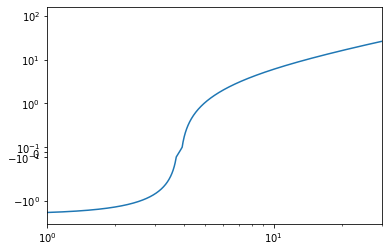

In [19]:
xs = 10.**np.arange(-2,2,.001) 
import pylab as pl
pl.semilogx(xs,xs*np.tanh(xs/2)**-1-4) 
ax = pl.gca()
ax.set_yscale('symlog',linthreshy=0.1,linscaley=0.1)
pl.xlim(1,30)

In [16]:
import matplotlib
matplotlib.scale.SymmetricalLogScale?

In [4]:
%matplotlib inline

#### define cooling function

In [2]:
import WiersmaCooling as Cool
Z2Zsun = 1/3.
z = 0.
# cooling = Cool.Wiersma_Cooling(Z2Zsun,z)
cooling = Cool.Kartick_Cooling()

In [2]:
import WiersmaCooling as Cool
Z2Zsun = 0.05
z = 4
cooling = Cool.Wiersma_Cooling(Z2Zsun,z)

../pysrc/WiersmaCooling.py:53: RuntimeWarning: invalid value encountered in log10
  vals = log(self.LAMBDA(X*un.K,Y*un.cm**-3).value)


In [10]:
vc = 80*un.km/un.s
r = 0.1*64*0.05**(1/3)*un.kpc
tff = (r/vc).to('Myr')
tcool = cooling.tcool(2.9e5*un.K, 0.13*un.cm**-3).to('Myr') 
print(tcool/tff)

0.0374147688381633


#### define potential

In [3]:
import HaloPotential as Halo
Rvir = 200*un.kpc
Rcirc=10*un.kpc
vc = 200*un.km/un.s
potential = Halo.PowerLaw_with_AngularMomentum(0,vc,Rvir,Rcirc)
#(lMhalo,Mgalaxy,z)

## integrate solution with angular momentum

In [4]:
spin = 0.035
Mdot=1*un.Msun/un.yr          #mass inflow rate
max_step = 0.01             #resolution of solution in ln(r)
v0 = 0.3*un.km/un.s           #radial velocity at circularization radius
R_max = 7.*Rvir              #outer radius of integration

In [5]:
res_AM = CF.shoot_from_R_circ(potential,cooling,R_circ=Rcirc,Mdot=Mdot,v0=v0,R_max=R_max,max_step=max_step,pr=True)

Integrated with log T(R_circ)=4.50, maximum radius reached 155 kpc, stop reason: unbound
Integrated with log T(R_circ)=4.25, maximum radius reached 840 kpc, stop reason: unbound


../pysrc/cooling_flow.py:64: RuntimeWarning: overflow encountered in double_scalars
  rho,T=e**ln_rho*un.g/un.cm**3, e**ln_T*un.K
/home/jonathan/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/jonathan/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
../pysrc/WiersmaCooling.py:59: RuntimeWarning: divide by zero encountered in log10
  return self.f_Cooling((log(T.to('K').value), log(nH.to('cm**-3').value))) * un.erg*un.cm**3/un.s
/home/jonathan/miniconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2507: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/jonathan/miniconda3/lib/python3.7/site-packa

Integrated with log T(R_circ)=4.12, maximum radius reached 642 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.19, maximum radius reached 1399 kpc, stop reason: max R reached


## plotting

In [6]:
import pylab as pl
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', family='serif', size=10)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
fig_width_half = 3.4

In [23]:
vphis = vc*Rcirc/res.Rs()
v_abs = (res.vs()**2 + vphis**2)**0.5
M_abs = res.Ms() * v_abs/res.vs()
Rsonic = np.interp(1,M_abs[::-1],res.Rs()[::-1])

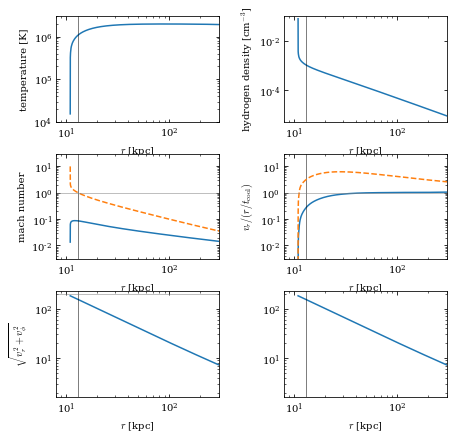

In [25]:
fig = pl.figure(figsize=(7,7))
pl.subplots_adjust(hspace=0.3,wspace=0.4)
for iPanel in range(6):
    pl.subplot(3,2,iPanel+1)
    res = res_AM
    if iPanel==0: ys = res.Ts()
    if iPanel==1: ys = res.nHs()
    if iPanel==2: ys = res.Ms()
    if iPanel==3: ys = res.t_cools() / res.t_flows()
    if iPanel==4: ys = v_abs
    pl.loglog(res.Rs(),ys)
    pl.xlim(8,300)
    pl.xlabel(r'$r$ [kpc]')
    pl.axvline(Rsonic.value,lw=0.5,c='k')
    if iPanel==0:
        pl.ylabel(r'temperature [K]')
        pl.ylim(1e4,3e6)
    if iPanel==1: 
        pl.ylabel(r'hydrogen density [cm$^{-3}$]')
        pl.ylim(0.5e-5,0.1)
    if iPanel==2:
        pl.plot(res.Rs(),ys * v_abs/res.vs(),ls='--')
        pl.ylabel(r'mach number')
        pl.ylim(0.003,30)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==3: 
        pl.ylabel(r'$v_r / (r/t_{\rm cool})$')
        pl.plot(res.Rs(),ys * v_abs/res.vs(),ls='--')
        pl.ylim(0.003,30)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==4: 
        pl.ylabel(r'$\sqrt{v_r^2 + v_\phi^2}$')
#         pl.ylim(0.03,3)
        pl.axhline(vc.value,c='.5',lw=0.5)
# pl.savefig('../figures/solutions_for_noneq_calculation.pdf',bbox_inches='tight')

In [37]:
str_AM = 'AM'
np.savez('../pyobjs/Mdot%d_vc%d'%(res.Mdot.value,vc.value)+str_AM+'.npz',
        nHs=res.nHs().to('cm**-3').value,
         Ts=res.Ts().to('K').value,
         vs=res.vs().to('km/s').value,
         rs=res.Rs().to('kpc').value)

## integrate solution without angular momentum

In [3]:
import HaloPotential as Halo
Rvir = 200*un.kpc
vc = 200*un.km/un.s
potential = Halo.PowerLaw(0,vc,Rvir)


In [6]:
R_sonic = 1*un.kpc
R_min = 0.1*un.kpc
max_step = 0.01             #resolution of solution in ln(r)
R_max = 7.*Rvir              #outer radius of integration

In [7]:
cooling

In [8]:
res_noAM = CF.shoot_from_sonic_point(potential,cooling,
                                     R_sonic=R_sonic,R_max=R_max,R_min=R_min,
                                     max_step=max_step,pr=True)

Integrated with v_c^2/c_s^2 (R_sonic) =1.000010;  maximum r=30 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.500005;  no transsonic solutions
Integrated with v_c^2/c_s^2 (R_sonic) =1.250008;  maximum r=10 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.125009;  maximum r=136 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.187508;  maximum r=579 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.156258;  maximum r=347 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.171883;  maximum r=978 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.179696;  maximum r=1399 kpc; stop reason: max R reached
Inward integration of supersonic part reached r = 0.100 kpc


In [9]:
res=res_noAM
res.Mdot

<Quantity 3.74673564 solMass / yr>

In [10]:
str_AM = 'noAM'
np.savez('../pyobjs/Mdot%.0f_vc%.0f'%(res.Mdot.value,vc.value)+str_AM+'.npz',
        nHs=res.nHs().to('cm**-3').value,
         Ts=res.Ts().to('K').value,
         vs=res.vs().to('km/s').value,
         rs=res.Rs().to('kpc').value)

In [11]:
import pylab as pl
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', family='serif', size=10)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
fig_width_half = 3.4

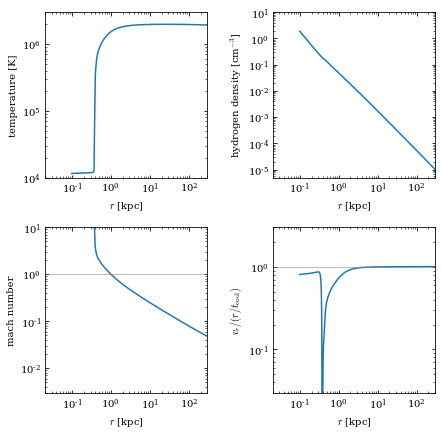

In [12]:
fig = pl.figure(figsize=(7,7))
pl.subplots_adjust(hspace=0.3,wspace=0.4)
for iPanel in range(4):
    pl.subplot(2,2,iPanel+1)
    res = res_noAM
    if iPanel==0: ys = res.Ts()
    if iPanel==1: ys = res.nHs()
    if iPanel==2: ys = res.Ms()
    if iPanel==3: ys = res.t_cools() / res.t_flows()
    pl.loglog(res.Rs(),ys)
    pl.xlim(0.02,300)
    pl.xlabel(r'$r$ [kpc]')
    if iPanel==0:
        pl.ylabel(r'temperature [K]')
        pl.ylim(1e4,3e6)
    if iPanel==1: 
        pl.ylabel(r'hydrogen density [cm$^{-3}$]')
        pl.ylim(0.5e-5,10)
    if iPanel==2: 
        pl.ylabel(r'mach number')
        pl.ylim(0.003,10)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==3: 
        pl.ylabel(r'$v_r / (r/t_{\rm cool})$')
        pl.ylim(0.03,3)
        pl.axhline(1.,c='.5',lw=0.5)
pl.savefig('../figures/solutions_for_noneq_calculation_noAM.pdf',bbox_inches='tight')